In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
import random
from albumentations import *
from tqdm import tqdm

In [2]:
AUG = [ HorizontalFlip, ShiftScaleRotate, RandomRotate90, RandomBrightnessContrast,
        Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, ]
print(len(AUG))

9


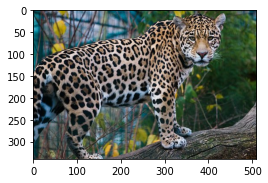

In [3]:
path0=r"/content/kaggle/jaguar/animal-world-3193850__340.jpg"
image0c=cv2.imread(path0)
aug=AUG[0](p=1)
image2c=aug(image=image0c)['image']
plt.figure(figsize=(4,4))
plt.imshow(cv2.cvtColor(image2c,cv2.COLOR_BGR2RGB))
plt.show()

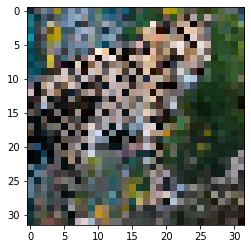

In [4]:
image0a=load_img(path0, grayscale=False, color_mode='rgb', target_size=(32,32))
image1a=np.asarray(image0a)
aug=AUG[0](p=1)
image2a=aug(image=image1a)['image']
plt.figure(figsize=(4,4))
plt.imshow(image2a)
plt.show()

In [5]:
data_dir = r"/content/kaggle"

In [6]:
Name=[]
for file in os.listdir(data_dir):
    Name+=[file]
print(Name)
print(len(Name))

['cheetah', 'tiger', 'jaguar', 'leopard', 'lion', '.ipynb_checkpoints']
6


In [7]:
N=[]
for i in range(len(Name)):
    N+=[i]

normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

In [8]:
dataset=[]
datalabel=[]
count=0
for file in tqdm(os.listdir(data_dir)):
    path=os.path.join(data_dir,file)
    for im in os.listdir(path):
        image0=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(32,32))
        image1=np.asarray(image0)
        for i in range(len(AUG)):
            aug=AUG[i](p=1)
            image2=aug(image=image1)['image']       
            image3=image2/255.0
            if image3.sum()>20:
                dataset+=[image3]
                datalabel+=[count]        
    count=count+1

100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


In [9]:
m=len(dataset)
print(m)
M=[]
for i in range(m):
    M+=[i]
random.seed(2021)
random.shuffle(M)

trainX=np.array(dataset)[M[0:(m//4)*3]]
testX=np.array(dataset)[M[(m//4)*3:]]
trainY=np.array(datalabel)[M[0:(m//4)*3]]
testY=np.array(datalabel)[M[(m//4)*3:]]

1530


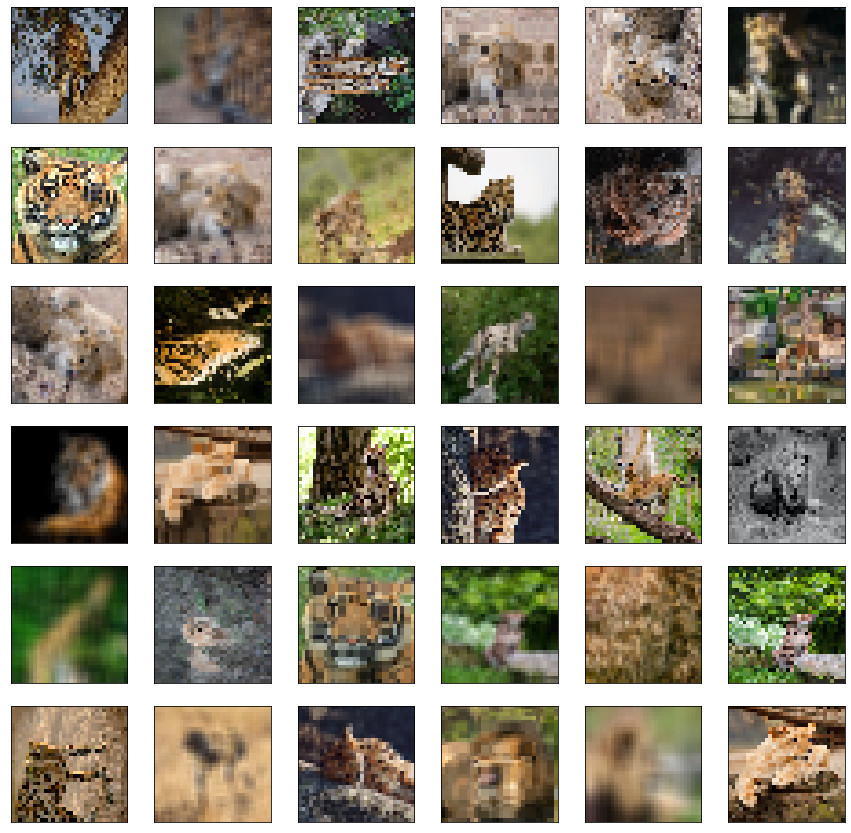

In [10]:
fig,axs = plt.subplots(6,6,figsize=(15,15))
for i in range(36):
    image=dataset[M[i]]
    r=i//6
    c=i%6
    axs[r][c].set_xticks([])
    axs[r][c].set_yticks([])
    ax=axs[r][c].imshow(image)
plt.show()

In [11]:
trainlabels1=to_categorical(trainY)
trainlabels=np.array(trainlabels1)

In [12]:
trainx,testx,trainy,testy=train_test_split(trainX,trainlabels,test_size=0.2,random_state=44)

In [13]:
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(916, 32, 32, 3)
(230, 32, 32, 3)
(916, 5)
(230, 5)


In [14]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

In [15]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(32,32,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

74850304/74836368 [==============================] - 1s 0us/step


In [16]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(5, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=40)

Epoch 1/40
29/29 [==============================] - 21s 346ms/step - loss: 1.5348 - accuracy: 0.3526 - val_loss: 1.3827 - val_accuracy: 0.4304
Epoch 2/40
29/29 [==============================] - 6s 222ms/step - loss: 1.3217 - accuracy: 0.4312 - val_loss: 1.2403 - val_accuracy: 0.4652
Epoch 3/40
29/29 [==============================] - 6s 216ms/step - loss: 1.1579 - accuracy: 0.5393 - val_loss: 1.2355 - val_accuracy: 0.4913
Epoch 4/40
29/29 [==============================] - 6s 221ms/step - loss: 1.1142 - accuracy: 0.5622 - val_loss: 1.1182 - val_accuracy: 0.5783
Epoch 5/40
29/29 [==============================] - 6s 219ms/step - loss: 1.0465 - accuracy: 0.5950 - val_loss: 1.0691 - val_accuracy: 0.5957
Epoch 6/40
29/29 [==============================] - 6s 218ms/step - loss: 0.9830 - accuracy: 0.6124 - val_loss: 1.0178 - val_accuracy: 0.6565
Epoch 7/40
29/29 [==============================] - 6s 218ms/step - loss: 0.9273 - accuracy: 0.6561 - val_loss: 1.0448 - val_accuracy: 0.5609
Epoch

In [19]:
testlabels1=to_categorical(testY)
testlabels=np.array(testlabels1)

In [20]:
y_pred=model.predict(testX)
pred=np.argmax(y_pred,axis=1)
ground=np.argmax(testlabels,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.59      0.79      0.68        91
           1       0.91      0.66      0.77        92
           2       0.63      0.70      0.66        67
           3       0.80      0.51      0.63        70
           4       0.75      0.88      0.81        64

    accuracy                           0.71       384
   macro avg       0.73      0.71      0.71       384
weighted avg       0.74      0.71      0.71       384



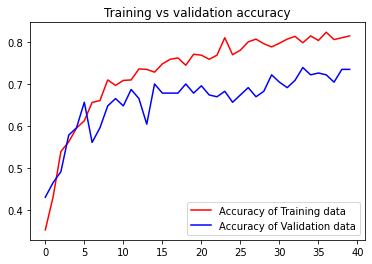

<Figure size 432x288 with 0 Axes>

In [21]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

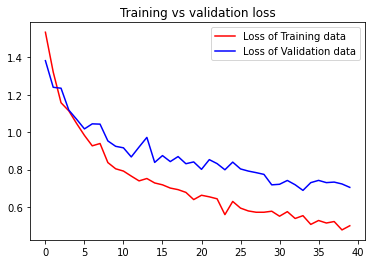

<Figure size 432x288 with 0 Axes>

In [22]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

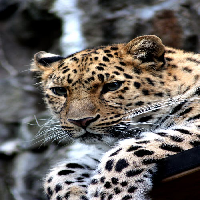

In [24]:
path0=r"/content/kaggle/leopard/leopard-animal-cat-cheetah-51129.jpeg"
load_img(path0,target_size=(200,200))

In [26]:
image=load_img(path0,target_size=(32,32))
image=img_to_array(image) 
image=image/255.0
prediction_image=np.expand_dims(image, axis=0)
print(prediction_image.shape)

(1, 32, 32, 3)


In [27]:
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=reverse_mapping[value]
print("Prediction is {}.".format(move_name))

Prediction is jaguar.


In [28]:
pred2=model.predict(testX)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]
print(PRED[0:10])

[3, 4, 1, 0, 4, 4, 0, 2, 3, 0]


In [29]:
ANS=list(testY)
print(ANS[0:10])

[3, 1, 1, 0, 4, 4, 0, 2, 3, 0]


In [30]:
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.7083333333333334


In [39]:
model.save("cluster.model", save_format="h5")

In [40]:
from google.colab import files
files.download("cluster.model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>